In [43]:
#### KGE and its components 

In [1]:
import numpy as np 
import pandas as pd 
import pickle
#loaded_discharge = np.load('/ec/res4/hpcperm/ecmv6565/forecast_analysis/discharge_array.npy')
loaded_stations = np.load('/ec/res4/hpcperm/ecmv6565/forecast_analysis/station_dict.npy', allow_pickle=True).item() # dictionary that matches the array index with the station ID 

In [2]:
# Load KGE and deterministic metrics result dict
with open("/ec/res4/hpcperm/ecmv6565/forecast_analysis/metrics_calculated_slurm.pkl", "rb") as f:
    metrics_calibrated = pickle.load(f)
with open("/ec/res4/hpcperm/ecmv6565/forecast_analysis_uncalibrated/metrics_calculated_slurm.pkl", "rb") as f:
    metrics_default = pickle.load(f)

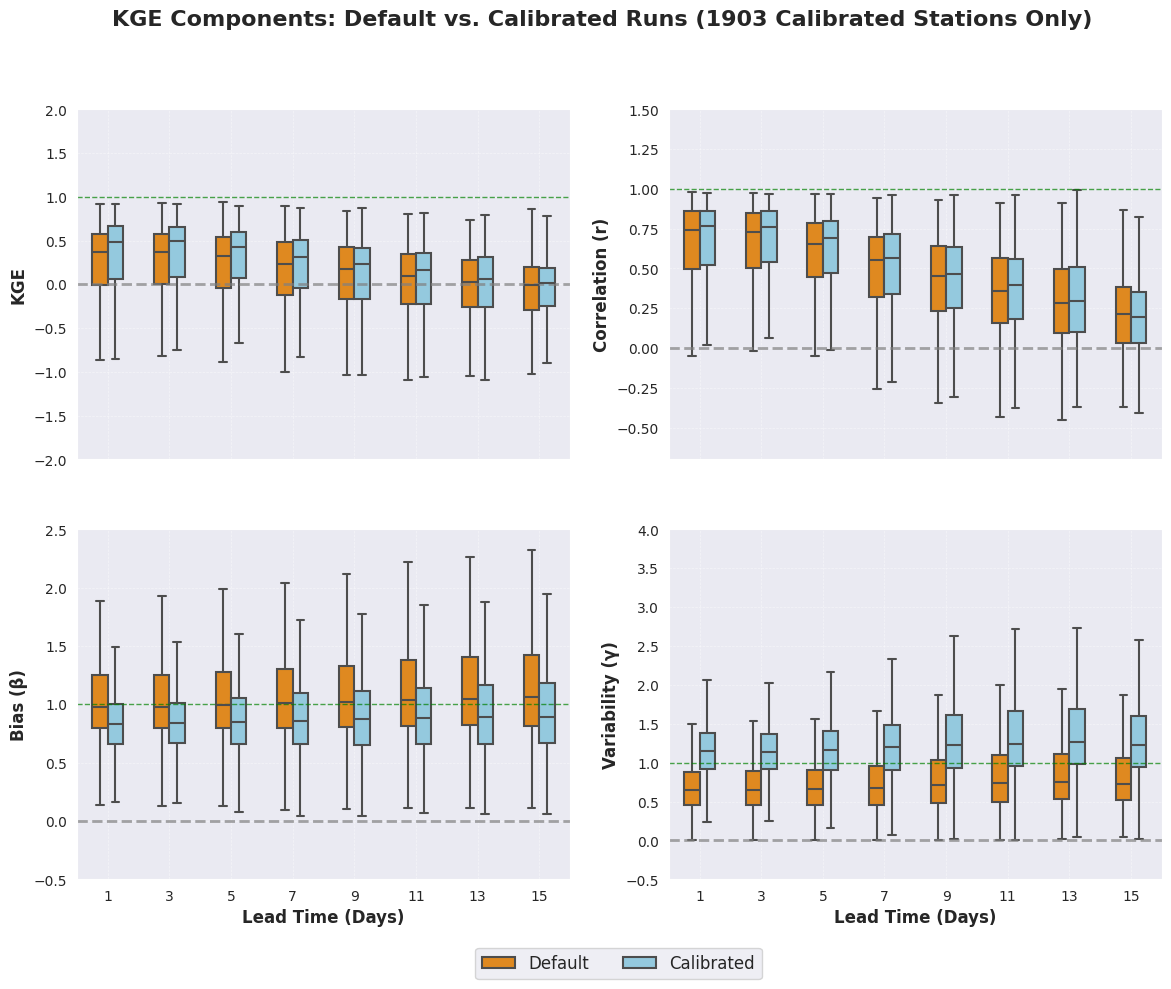

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



def plot_comparison_metrics(kge_dict_default, kge_dict_calibrated, metrics, csv_path, station_info, loaded_stations, calibrated_only=True):
    """
    Plot and compare multiple chosen metrics (Default vs. Calibrated) across selected lead times.

    This function generates side-by-side box plots comparing default and calibrated model runs for each specified metric
    across various lead times. The plots can either include all stations or only those marked as calibrated (EC_calib > 0).

    Parameters:
    - kge_dict_default (dict): Dictionary containing the uncalibrated (default) metric values.
    - kge_dict_calibrated (dict): Dictionary containing the calibrated metric values.
    - metrics (list): List of metrics to plot (e.g., ['KGE', 'r', 'Beta', 'Gamma']).
    - csv_path (str): Path to the CSV file containing reference median values.
    - station_info (pd.DataFrame): DataFrame containing station metadata (includes 'ObsID' and 'EC_calib').
    - loaded_stations (dict): Dictionary mapping station indices to their IDs.
    - calibrated_only (bool): If True, only plots stations where 'EC_calib' > 0. If False, plots all stations.

    Returns:
    - Displays the generated plots and prints the number of stations considered.
    """

    y_limits = {
        "KGE": (-2, 2),
        "r": (-0.7, 1.5),
        "Beta": (-0.5, 2.5),
        "Gamma": (-0.5, 4)
    }

    metric_labels = {
        "KGE": "KGE",
        "r": "Correlation (r)",
        "Beta": "Bias (β)",
        "Gamma": "Variability (γ)"
    }

    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    num_stations = len(valid_station_indices)

    df = pd.read_csv(csv_path)
    selected_days = list(range(1, 16, 2))
    selected_time_steps = [(day * 4 - 1) for day in selected_days]

    ensemble = 0  
    sns.set_style("darkgrid")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()
    colors = ["#FF8C00", "skyblue"]

    for i, metric in enumerate(metrics):
        metric_values_calibrated = np.array([
            [kge_dict_calibrated[metric][lead_time][ensemble][st] for st in valid_station_indices] 
            for lead_time in selected_time_steps
        ])

        metric_values_default = np.array([
            [kge_dict_default[metric][lead_time][ensemble][st] for st in valid_station_indices] 
            for lead_time in selected_time_steps
        ])

        df_plot = []
        for j, day in enumerate(selected_days):
            for val in metric_values_default[j]:
                df_plot.append([day, val, "Default"])
            for val in metric_values_calibrated[j]:
                df_plot.append([day, val, "Calibrated"])

        df_plot = pd.DataFrame(df_plot, columns=["Lead Time", "Value", "Run Type"])

        sns.boxplot(
            data=df_plot,
            x="Lead Time",
            showfliers=False,
            y="Value",
            hue="Run Type",
            ax=axes[i],
            palette={"Default": colors[0], "Calibrated": colors[1]},
            width=0.5,
            linewidth=1.5
        )

        axes[i].set_ylabel(metric_labels[metric], fontsize=12, fontweight="bold")
        axes[i].set_xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
        axes[i].set_xticks(range(len(selected_days)))
        axes[i].set_xticklabels(selected_days, fontsize=10)
        axes[i].set_ylim(y_limits[metric])

        axes[i].axhline(y=0, color="gray", linestyle="--", linewidth=2, alpha=0.7)
        axes[i].axhline(y=1, color="green", linestyle="--", linewidth=1, alpha=0.7)
        axes[i].grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    title_type = "Calibrated Stations Only" if calibrated_only else "All Stations"
    fig.suptitle(f"KGE Components: Default vs. Calibrated Runs ({num_stations} {title_type})", fontsize=16, fontweight="bold")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, fontsize=12, frameon=True, bbox_to_anchor=(0.62, 0.05))

    for ax in axes:
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

    plt.show()
metrics_to_plot = ["KGE", "r", "Beta", "Gamma"]
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')
loaded_stations = np.load('/ec/res4/hpcperm/ecmv6565/forecast_analysis/station_dict.npy', allow_pickle=True).item()
csv_path = "/ec/res4/hpcperm/ecmv6565/timeseries_stations/statistics_calibrated_p3.csv"
plot_comparison_metrics(metrics_default, metrics_calibrated, metrics_to_plot, csv_path, station_info, loaded_stations, calibrated_only =True)



In [4]:
#### KGESS

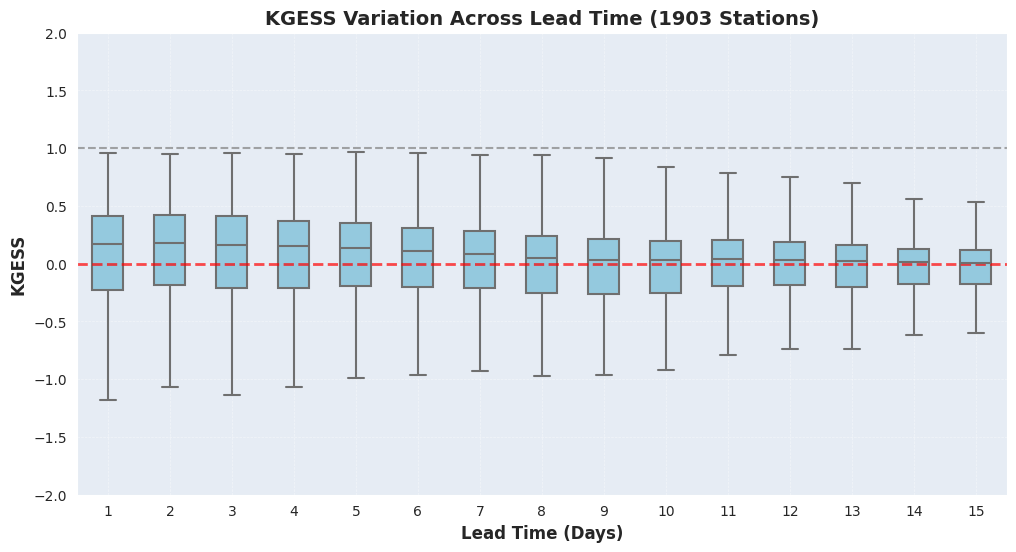

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_kgess(kge_dict_default, kge_dict_calibrated):
    """
    Calculate the KGE Skill Score (KGESS) between the default and calibrated runs.

    Parameters:
        kge_dict_default (dict): Dictionary containing the uncalibrated (default) KGE values.
        kge_dict_calibrated (dict): Dictionary containing the calibrated KGE values.

    Returns:
        kgess_dict (dict): Dictionary containing KGESS values for each lead time and station.
                          Format: {lead_time: {station: kgess_value}}
    """
    kgess_dict = {}
    lead_times = kge_dict_default["KGE"].keys()

    for lead_time in lead_times:
        kgess_dict[lead_time] = {}
        for station in range(len(kge_dict_default["KGE"][lead_time][0])):
            kge_default = kge_dict_default["KGE"][lead_time][0][station]
            kge_calibrated = kge_dict_calibrated["KGE"][lead_time][0][station]

            if not np.isnan(kge_default) and not np.isnan(kge_calibrated):
                kgess = (kge_calibrated - kge_default) / (1 - kge_default)
            else:
                kgess = np.nan

            kgess_dict[lead_time][station] = kgess

    return kgess_dict


def plot_kgess(kgess_dict, selected_days, num_stations, station_info, loaded_stations, calibrated_only=True):
    """
    Plot the KGE Skill Score (KGESS) across lead times using box plots.

    Parameters:
        kgess_dict (dict): Dictionary containing KGESS values for each lead time and station.
        selected_days (list): List of selected lead times in days.
        num_stations (int): Number of stations considered for the plot.
        station_info (DataFrame): DataFrame containing station calibration information.
        loaded_stations (dict): Dictionary mapping station indices to ObsID.
        calibrated_only (bool): Whether to filter for calibrated stations only.
    """
    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    selected_time_steps = [(day * 4 - 1) for day in selected_days]
    kgess_data = []

    for day, lead_time in zip(selected_days, selected_time_steps):
        if lead_time in kgess_dict:
            for station, kgess_value in kgess_dict[lead_time].items():
                if not np.isnan(kgess_value) and (station in valid_station_indices):
                    kgess_data.append([day, station, kgess_value])

    df_kgess = pd.DataFrame(kgess_data, columns=["Lead Time (Days)", "Station", "KGESS"])

    sns.set_style("darkgrid")
    background_color = "#E6ECF4"
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_facecolor(background_color)

    sns.boxplot(data=df_kgess, x="Lead Time (Days)", y="KGESS", width=0.5, showfliers=False, color="skyblue", linewidth=1.5)

    plt.title(f"KGESS Variation Across Lead Time ({len(valid_station_indices)} Stations)", fontsize=14, fontweight="bold")
    plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
    plt.ylabel("KGESS", fontsize=12, fontweight="bold")
    plt.ylim(-2, 2)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    plt.axhline(y=1, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    plt.show()

def kgess_analysis(kge_dict_default, kge_dict_calibrated, station_info, loaded_stations, selected_days, calibrated_only=True):
    kgess_dict = calculate_kgess(kge_dict_default, kge_dict_calibrated)
    num_stations = len(loaded_stations)
    plot_kgess(kgess_dict, selected_days, num_stations, station_info, loaded_stations, calibrated_only)


selected_days = list(range(1, 16))

kgess_analysis(metrics_default, metrics_calibrated, station_info, loaded_stations, selected_days, calibrated_only=True)


In [6]:
# KGESS hued by Area

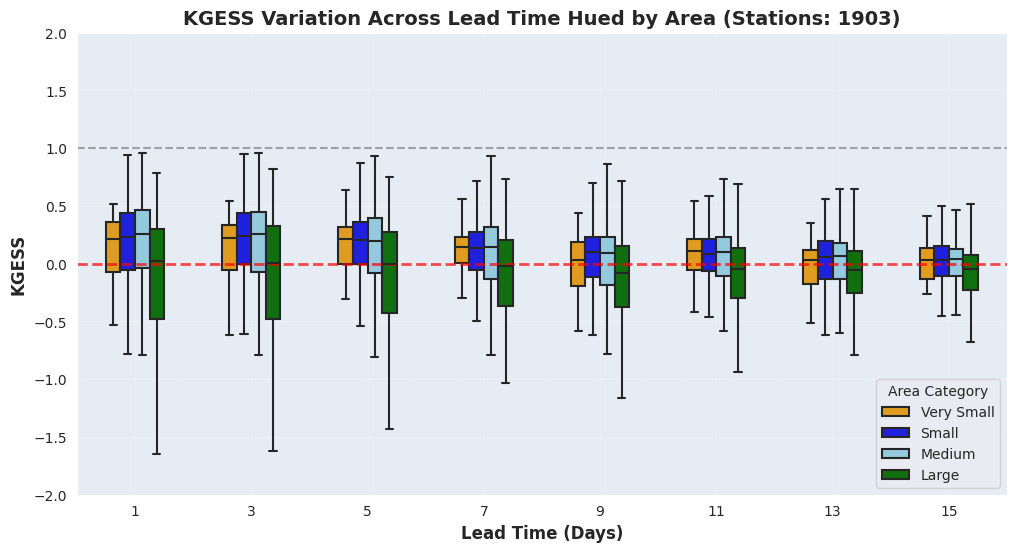

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_kgess(kgess_dict, selected_days, station_info_path, loaded_stations, calibrated_only=True):
    """
    Plot the KGE Skill Score (KGESS) across lead times using box plots.

    Parameters:
        kgess_dict (dict): Dictionary containing KGESS values for each lead time and station.
        selected_days (list): List of selected lead times in days.
        station_info_path (str): Path to the CSV file containing station drainage area info.
        loaded_stations (dict): Dictionary mapping station indices to ObsID.
        calibrated_only (bool): Whether to filter for calibrated stations only.
    """
    station_info = pd.read_csv(station_info_path)
    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    station_info = station_info[['ObsID', 'DrainingArea.km2.LDD']]
    small_threshold = station_info['DrainingArea.km2.LDD'].quantile(0.25)
    small_2_threshold = station_info['DrainingArea.km2.LDD'].quantile(0.5)
    medium_threshold = station_info['DrainingArea.km2.LDD'].quantile(0.75)

    def categorize_area(area):
        if area <= small_threshold:
            return "Very Small"
        elif area <= small_2_threshold:
            return "Small"
        elif area <= medium_threshold:
            return "Medium"
        else:
            return "Large"

    station_info['Area Category'] = station_info['DrainingArea.km2.LDD'].apply(categorize_area)
    area_category_dict = station_info.set_index('ObsID')['Area Category'].to_dict()

    selected_time_steps = [(day * 4 - 1) for day in selected_days]

    kgess_data = []
    for day, lead_time in zip(selected_days, selected_time_steps):
        if lead_time in kgess_dict:
            for station, kgess_value in kgess_dict[lead_time].items():
                if not np.isnan(kgess_value) and station in valid_station_indices:
                    area_category = area_category_dict.get(int(loaded_stations[station]), "Unknown")
                    kgess_data.append([day, station, kgess_value, area_category])

    df_kgess = pd.DataFrame(kgess_data, columns=["Lead Time (Days)", "Station", "KGESS", "Area Category"])

    sns.set_style("darkgrid")  
    background_color = "#E6ECF4"  

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_facecolor(background_color)

    sns.boxplot(
        data=df_kgess, x="Lead Time (Days)", y="KGESS", hue="Area Category",
        width=0.5, showfliers=False,
        palette={"Very Small": "orange","Small": "blue", "Medium": "skyblue", "Large": "green"},
        hue_order=["Very Small", "Small", "Medium", "Large"],
        linewidth=1.5
    )

    plt.title(f"KGESS Variation Across Lead Time Hued by Area (Stations: {len(valid_station_indices)})", fontsize=14, fontweight="bold")
    plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
    plt.ylabel("KGESS", fontsize=12, fontweight="bold")

    plt.ylim(-2, 2)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    plt.axhline(y=1, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    plt.legend(title="Area Category", fontsize=10)
    plt.show()


selected_days = list(range(1, 16,2))
station_info_path = '/home/ecmv6565/Downloads/outlets_updated.csv'
kgess_dict = calculate_kgess(metrics_default, metrics_calibrated)
plot_kgess(kgess_dict, selected_days, station_info_path, loaded_stations, calibrated_only=True)


In [7]:
# KGESS hued by elevation 

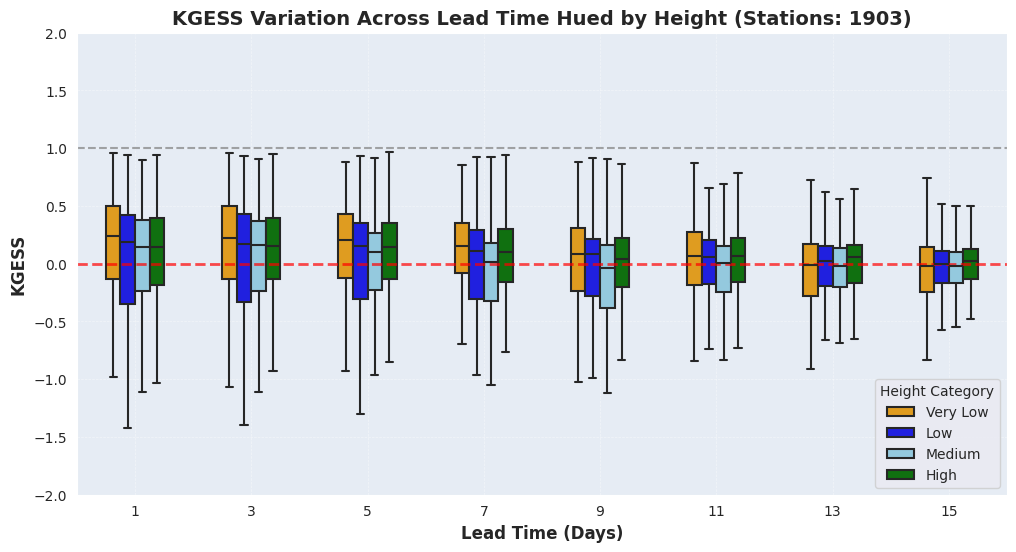

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_kgess(kgess_dict, selected_days, station_info_path, loaded_stations, calibrated_only=True):
    """
    Plot the KGE Skill Score (KGESS) across lead times using box plots.

    Parameters:
        kgess_dict (dict): Dictionary containing KGESS values for each lead time and station.
        selected_days (list): List of selected lead times in days.
        station_info_path (str): Path to the CSV file containing station drainage area info.
        loaded_stations (dict): Dictionary mapping station indices to ObsID.
        calibrated_only (bool): Whether to filter for calibrated stations only.
    """
    station_info = pd.read_csv(station_info_path)
    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    station_info = station_info[['ObsID', 'Height']]
    small_threshold = station_info['Height'].quantile(0.25)
    small_2_threshold = station_info['Height'].quantile(0.5)
    medium_threshold = station_info['Height'].quantile(0.75)

    def categorize_area(area):
        if area <= small_threshold:
            return "Very Low"
        elif area <= small_2_threshold:
            return "Low"
        elif area <= medium_threshold:
            return "Medium"
        else:
            return "High"

    station_info['Height Category'] = station_info['Height'].apply(categorize_area)
    area_category_dict = station_info.set_index('ObsID')['Height Category'].to_dict()

    selected_time_steps = [(day * 4 - 1) for day in selected_days]

    kgess_data = []
    for day, lead_time in zip(selected_days, selected_time_steps):
        if lead_time in kgess_dict:
            for station, kgess_value in kgess_dict[lead_time].items():
                if not np.isnan(kgess_value) and station in valid_station_indices:
                    area_category = area_category_dict.get(int(loaded_stations[station]), "Unknown")
                    kgess_data.append([day, station, kgess_value, area_category])

    df_kgess = pd.DataFrame(kgess_data, columns=["Lead Time (Days)", "Station", "KGESS", "Height Category"])

    sns.set_style("darkgrid")  
    background_color = "#E6ECF4"  

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_facecolor(background_color)

    sns.boxplot(
        data=df_kgess, x="Lead Time (Days)", y="KGESS", hue="Height Category",
        width=0.5, showfliers=False,
        palette={"Very Low": "orange","Low": "blue", "Medium": "skyblue", "High": "green"},
        hue_order=["Very Low", "Low", "Medium", "High"],
        linewidth=1.5
    )

    plt.title(f"KGESS Variation Across Lead Time Hued by Height (Stations: {len(valid_station_indices)})", fontsize=14, fontweight="bold")
    plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
    plt.ylabel("KGESS", fontsize=12, fontweight="bold")

    plt.ylim(-2, 2)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    plt.axhline(y=1, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    plt.legend(title="Height Category", fontsize=10)
    plt.show()


selected_days = list(range(1, 16,2))
station_info_path = '/home/ecmv6565/Downloads/outlets_updated.csv'
kgess_dict = calculate_kgess(metrics_default, metrics_calibrated)
plot_kgess(kgess_dict, selected_days, station_info_path, loaded_stations, calibrated_only=True)


In [10]:
# CRPSS 

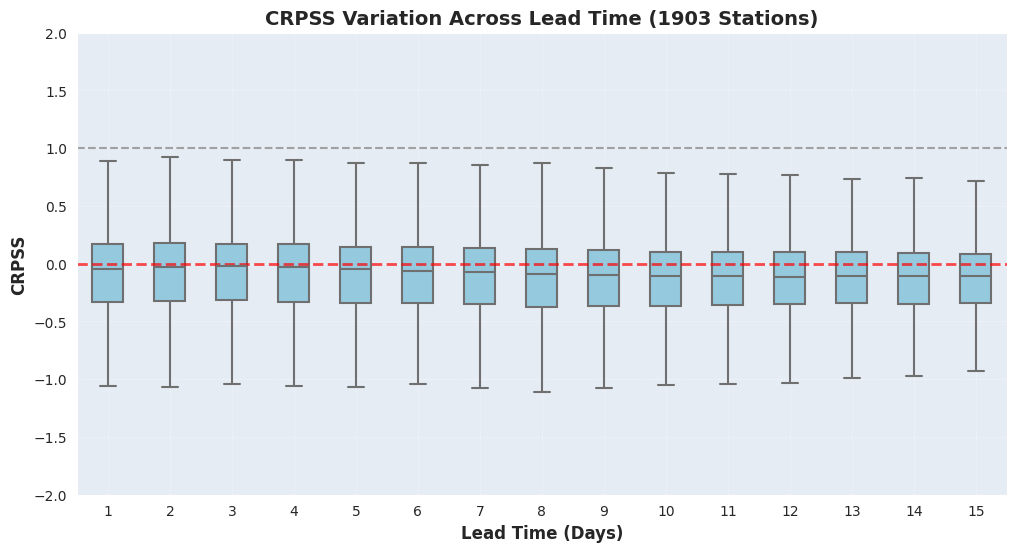

In [9]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_crpss(crps_forecast_dict, crps_forecast_dict_default):
    """
    Calculate the CRPSS between forecasted and persistence CRPS values.

    Parameters:
        crps_forecast_dict (dict): Forecasted CRPS values.
        crps_forecast_dict_default (dict): Persistence (reference) CRPS values.

    Returns:
        crpss_dict (dict): Dictionary containing CRPSS values for each lead time and station.
    """
    crpss_dict = {}
    for lead_time in crps_forecast_dict.keys():
        crpss_dict[lead_time] = {}
        for station in crps_forecast_dict[lead_time].keys():
            crps_forecast = crps_forecast_dict[lead_time].get(station, np.nan)
            crps_persistence = crps_forecast_dict_default[lead_time].get(station, np.nan)

            if not np.isnan(crps_forecast) and not np.isnan(crps_persistence):
                crpss_dict[lead_time][station] = 1 - (crps_forecast / crps_persistence)
            else:
                crpss_dict[lead_time][station] = np.nan

    return crpss_dict

def plot_crpss(crpss_dict, selected_days, station_info, loaded_stations, calibrated_only=True):
    selected_time_steps = [(day * 4 - 1) for day in selected_days]

    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    crpss_data = []
    for lead_time, day in zip(selected_time_steps, selected_days):
        if lead_time in crpss_dict:
            for station, crpss_value in crpss_dict[lead_time].items():
                if not np.isnan(crpss_value) and int(loaded_stations[station]) in valid_station_indices:
                    crpss_data.append([day, station, crpss_value])

    num_stations = len(valid_station_indices)

    df_crpss = pd.DataFrame(crpss_data, columns=["Lead Time (Days)", "Station", "CRPSS"])

    sns.set_style("darkgrid")
    background_color = "#E6ECF4"

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_facecolor(background_color)

    sns.boxplot(data=df_crpss, x="Lead Time (Days)", y="CRPSS", width=0.5, showfliers=False,
                color="skyblue", linewidth=1.5)

    plt.title(f"CRPSS Variation Across Lead Time ({num_stations} Stations)", fontsize=14, fontweight="bold")
    plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
    plt.ylabel("CRPSS", fontsize=12, fontweight="bold")

    plt.ylim(-2, 2)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    plt.axhline(y=1, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    plt.show()

# Load CRPS results
crps_forecast_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_results.pkl"
crps_forecast_path_default = "/ec/res4/hpcperm/ecmv6565/forecast_analysis_uncalibrated/crps_results.pkl"

with open(crps_forecast_path, "rb") as f:
    crps_forecast_dict = pickle.load(f)

with open(crps_forecast_path_default, "rb") as f:
    crps_forecast_dict_default = pickle.load(f)

crpss_dict = calculate_crpss(crps_forecast_dict, crps_forecast_dict_default)
selected_days = [x for x in range(1, 16)]
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')

plot_crpss(crpss_dict, selected_days, station_info, loaded_stations, calibrated_only= True)


In [12]:
# CRPSS hued by area 

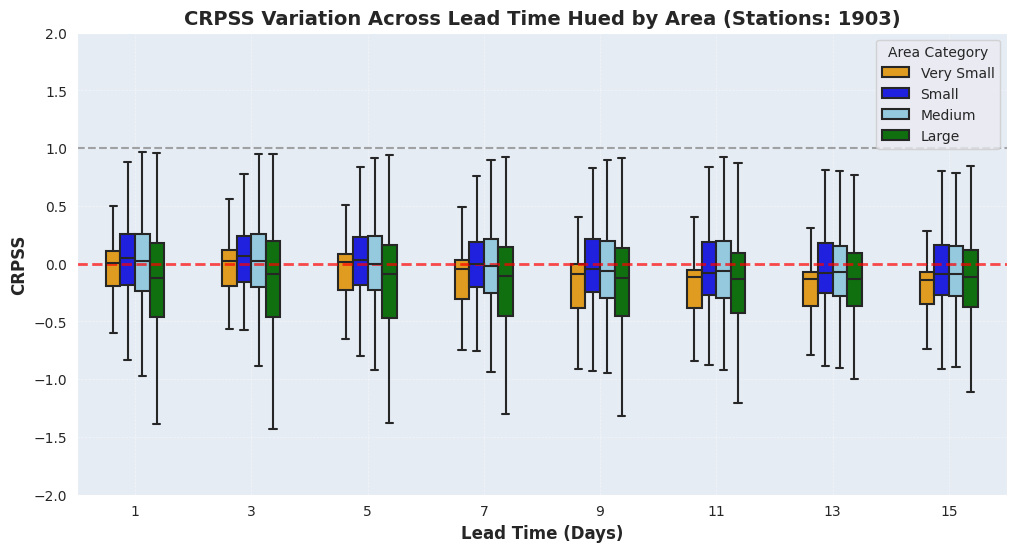

In [10]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_crpss_Area(crps_forecast_path, crps_persistence_path, selected_days, station_info_path, loaded_stations, calibrated_only=True):
    """
    Plot the Continuous Ranked Probability Skill Score (CRPSS) across lead times using box plots.

    Parameters:
        crps_forecast_path (str): Path to the pickle file containing forecast CRPS results.
        crps_persistence_path (str): Path to the pickle file containing persistence CRPS results.
        selected_days (list): List of selected lead times in days.
        station_info_path (str): Path to the CSV file containing station drainage area info.
        loaded_stations (dict): Dictionary mapping station indices to ObsID.
        calibrated_only (bool): Whether to filter for calibrated stations only.
    """
    # Load CRPS results
    with open(crps_forecast_path, "rb") as f:
        crps_forecast_dict = pickle.load(f)

    with open(crps_persistence_path, "rb") as f:
        crps_persistence_dict = pickle.load(f)

    # Load station info
    station_info = pd.read_csv(station_info_path)
    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    station_info = station_info[['ObsID', 'DrainingArea.km2.LDD']]
    
    # Define area categories
    small_threshold = station_info['DrainingArea.km2.LDD'].quantile(0.25)
    small_2_threshold = station_info['DrainingArea.km2.LDD'].quantile(0.5)
    medium_threshold = station_info['DrainingArea.km2.LDD'].quantile(0.75)

    def categorize_area(area):
        if area <= small_threshold:
            return "Very Small"
        elif area <= small_2_threshold:
            return "Small"
        elif area <= medium_threshold:
            return "Medium"
        else:
            return "Large"

    station_info['Area Category'] = station_info['DrainingArea.km2.LDD'].apply(categorize_area)
    area_category_dict = station_info.set_index('ObsID')['Area Category'].to_dict()

    selected_time_steps = [(day * 4 - 1) for day in selected_days]

    # Compute CRPSS
    crpss_data = []
    for lead_time, day in zip(selected_time_steps, selected_days):
        if lead_time in crps_forecast_dict:
            for station, crps_forecast in crps_forecast_dict[lead_time].items():
                if station in valid_station_indices:
                    crps_persistence = crps_persistence_dict[lead_time].get(station, np.nan)
                    if not np.isnan(crps_forecast) and not np.isnan(crps_persistence):
                        crpss_value = 1 - (crps_forecast / crps_persistence)
                        area_category = area_category_dict.get(int(loaded_stations[station]), "Unknown")
                        crpss_data.append([day, station, crpss_value, area_category])

    df_crpss = pd.DataFrame(crpss_data, columns=["Lead Time (Days)", "Station", "CRPSS", "Area Category"])

    sns.set_style("darkgrid")  
    background_color = "#E6ECF4"  

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_facecolor(background_color)

    sns.boxplot(
        data=df_crpss, x="Lead Time (Days)", y="CRPSS", hue="Area Category",
        width=0.5, showfliers=False,
        palette={"Very Small": "orange", "Small": "blue", "Medium": "skyblue", "Large": "green"},
        hue_order=["Very Small", "Small", "Medium", "Large"],
        linewidth=1.5
    )

    plt.title(f"CRPSS Variation Across Lead Time Hued by Area (Stations: {len(valid_station_indices)})", fontsize=14, fontweight="bold")
    plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
    plt.ylabel("CRPSS", fontsize=12, fontweight="bold")

    plt.ylim(-2, 2)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    plt.axhline(y=1, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    plt.legend(title="Area Category", fontsize=10)
    plt.show()
crps_forecast_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_results.pkl"
crps_persistence_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis_uncalibrated/crps_results.pkl"
selected_days = [x for x in range(1, 16,2)]
plot_crpss_Area(crps_forecast_path, crps_persistence_path, selected_days, station_info_path, loaded_stations, calibrated_only=True)

In [11]:
# CRPS Hued by eleveatoin 

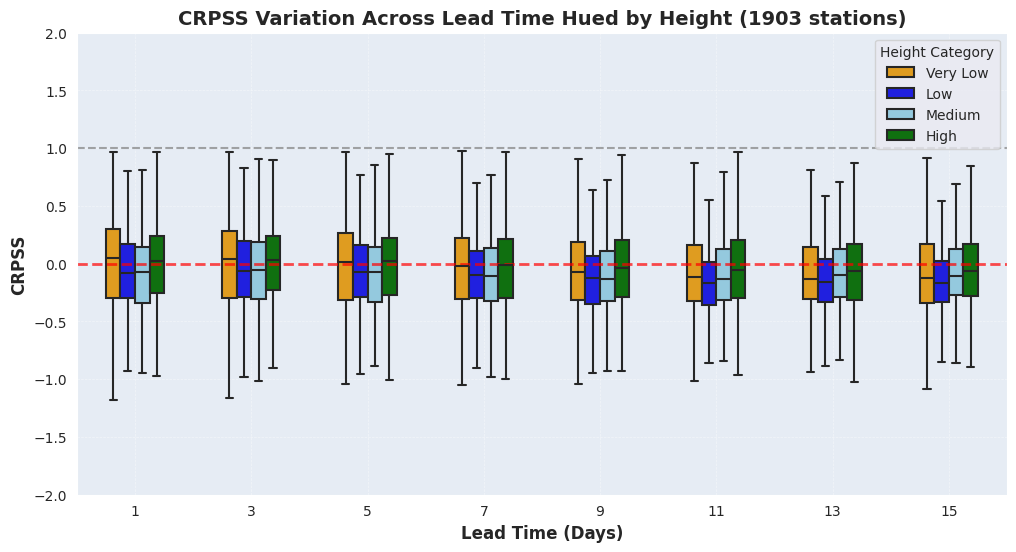

In [14]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_crpss_by_height(crps_forecast_dict, crps_forecast_dict_default, selected_days, station_info_path, loaded_stations, calibrated_only=True):
    """
    Plot the Continuous Ranked Probability Skill Score (CRPSS) across lead times using box plots categorized by Height.

    Parameters:
        crps_forecast_dict (dict): Dictionary containing forecast CRPS values.
        crps_forecast_dict_default (dict): Dictionary containing persistence CRPS values.
        selected_days (list): List of selected lead times in days.
        station_info_path (str): Path to the CSV file containing station height info.
        loaded_stations (dict): Dictionary mapping station indices to ObsID.
        calibrated_only (bool): Whether to filter for calibrated stations only.
    """
    station_info = pd.read_csv(station_info_path)
    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    station_info = station_info[['ObsID', 'Height']]
    
    small_threshold = station_info['Height'].quantile(0.25)
    small_2_threshold = station_info['Height'].quantile(0.5)
    medium_threshold = station_info['Height'].quantile(0.75)

    def categorize_area(area):
        if area <= small_threshold:
            return "Very Low"
        elif area <= small_2_threshold:
            return "Low"
        elif area <= medium_threshold:
            return "Medium"
        else:
            return "High"

    station_info['Height Category'] = station_info['Height'].apply(categorize_area)
    area_category_dict = station_info.set_index('ObsID')['Height Category'].to_dict()

    selected_time_steps = [(day * 4 - 1) for day in selected_days]

    crpss_data = []
    for day, lead_time in zip(selected_days, selected_time_steps):
        if lead_time in crps_forecast_dict:
            for station, crps_forecast in crps_forecast_dict[lead_time].items():
                crps_default = crps_forecast_dict_default[lead_time].get(station, np.nan)
                if not np.isnan(crps_forecast) and not np.isnan(crps_default) and station in valid_station_indices:
                    crpss_value = 1 - (crps_forecast / crps_default)
                    area_category = area_category_dict.get(int(loaded_stations[station]), "Unknown")
                    crpss_data.append([day, station, crpss_value, area_category])

    df_crpss = pd.DataFrame(crpss_data, columns=["Lead Time (Days)", "Station", "CRPSS", "Height Category"])

    sns.set_style("darkgrid")
    background_color = "#E6ECF4"

    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_facecolor(background_color)

    sns.boxplot(
        data=df_crpss, x="Lead Time (Days)", y="CRPSS", hue="Height Category",
        width=0.5, showfliers=False,
        palette={"Very Low": "orange", "Low": "blue", "Medium": "skyblue", "High": "green"},
        hue_order=["Very Low", "Low", "Medium", "High"],
        linewidth=1.5
    )

    plt.title(f"CRPSS Variation Across Lead Time Hued by Height ({len(valid_station_indices)} stations)", fontsize=14, fontweight="bold")
    plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
    plt.ylabel("CRPSS", fontsize=12, fontweight="bold")

    plt.ylim(-2, 2)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    plt.axhline(y=1, color="gray", linestyle="--", linewidth=1.5, alpha=0.7)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    plt.legend(title="Height Category", fontsize=10)
    plt.show()

plot_crpss_by_height(crps_forecast_dict, crps_forecast_dict_default, selected_days, station_info_path, loaded_stations, calibrated_only=True)


In [18]:
## spatial maps KGESS and CRPSS

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import pickle
from matplotlib.cm import ScalarMappable

sns.reset_orig()

def plot_metric_spatial_multiple_lead_times(metric_dict, station_info, lead_times, loaded_stations, filename, metric_name="CRPSS", calibrated_only=False):
    """
    Plots the specified metric (e.g., CRPSS or KGESS) for all stations for multiple lead times.

    Parameters:
        metric_dict (dict): Dictionary containing metric values for each lead time and station.
        station_info (pd.DataFrame): DataFrame containing station metadata.
        lead_times (list): List of lead times for which the metric is plotted.
        loaded_stations (dict): Mapping of station indices to station IDs.
        filename (str): File name to save the plot.
        metric_name (str): Name of the metric (e.g., "CRPSS" or "KGESS"). Default is "CRPSS".
        calibrated_only (bool): Whether to plot only calibrated stations. Default is False (plot all stations).
    """
    if calibrated_only:
        valid_station_ids = station_info.loc[station_info['EC_calib'] > 0, 'ObsID'].tolist()
        valid_station_indices = [idx for idx, obs_id in loaded_stations.items() if int(obs_id) in valid_station_ids]
    else:
        valid_station_indices = list(loaded_stations.keys())

    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    categories = [
        {'label': '< 0', 'condition': lambda x: x < 0, 'color': '#0D0887'},
        {'label': '0 - 0.3', 'condition': lambda x: (x >= 0) & (x < 0.3), 'color': '#D11A7C'},
        {'label': '0.3 - 0.65', 'condition': lambda x: (x >= 0.3) & (x < 0.65), 'color': '#FF8C00'},
        {'label': '> 0.65', 'condition': lambda x: x >= 0.65, 'color': '#FFFF00'}
    ]

    for i, lead_time in enumerate(lead_times):
        ax = axes[i]
        ax.set_extent([-15, 30, 35, 75], crs=ccrs.PlateCarree())

        ax.add_feature(cfeature.LAND, edgecolor='gray', facecolor='gray', alpha=0.8)
        ax.add_feature(cfeature.OCEAN, facecolor="#B0E0E6", alpha=0.5)

        for spine in ax.spines.values():
            spine.set_edgecolor('gray')
            spine.set_linewidth(1)

        station_ids = []
        metric_values = []

        if lead_time in metric_dict:
            for station, metric_value in metric_dict[lead_time].items():
                if station in valid_station_indices and not np.isnan(metric_value):
                    station_ids.append(loaded_stations[station])
                    metric_values.append(metric_value)

        metric_df = pd.DataFrame({'station_id': station_ids, metric_name: metric_values})

        metric_df['station_id'] = metric_df['station_id'].astype(str)
        station_info['ObsID'] = station_info['ObsID'].astype(str)

        merged_data = pd.merge(metric_df, station_info, how='left', left_on='station_id', right_on='ObsID')

        merged_data = merged_data.dropna(subset=[metric_name])
        merged_data = merged_data[merged_data[metric_name] >= -50]

        for category in categories:
            filtered_data = merged_data[category['condition'](merged_data[metric_name])]
            ax.scatter(
                filtered_data['StationLon'], filtered_data['StationLat'],
                color=category['color'], label=category['label'], alpha=0.8, s=5
            )

        ax.set_title(f'lt={int((lead_time + 1) / 4)} days', fontsize=12)

    handles, labels = axes[0].get_legend_handles_labels()
    custom_handles = [plt.Line2D([], [], color=cat['color'], marker='o', linestyle='None', markersize=12) for cat in categories]

    fig.legend(custom_handles, [cat['label'] for cat in categories], title=f'{metric_name} Categories ({len(valid_station_indices)} stations)', loc='lower center', bbox_to_anchor=(0.5, 0.1), ncol=4, fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2, wspace=-0.1, hspace=0.15)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()


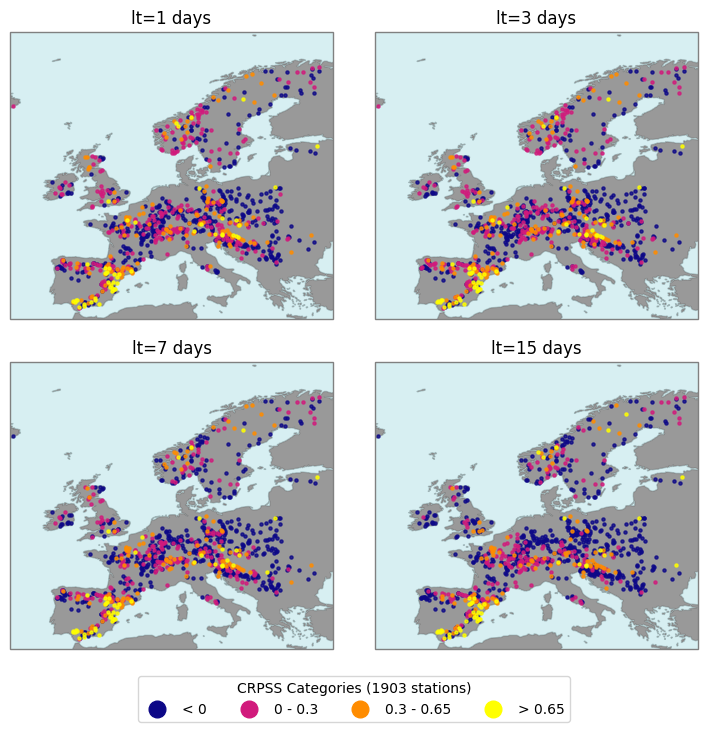

In [16]:
# Example usage for CRPSS
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')  # Load station metadata
lead_times = [3, 11, 27, 59]  # Choose desired lead times
plot_metric_spatial_multiple_lead_times(crpss_dict, station_info, lead_times, loaded_stations, 'crpss_map_multiple_lead_times.png', metric_name="CRPSS", calibrated_only=True)

# Example usage for KGESS


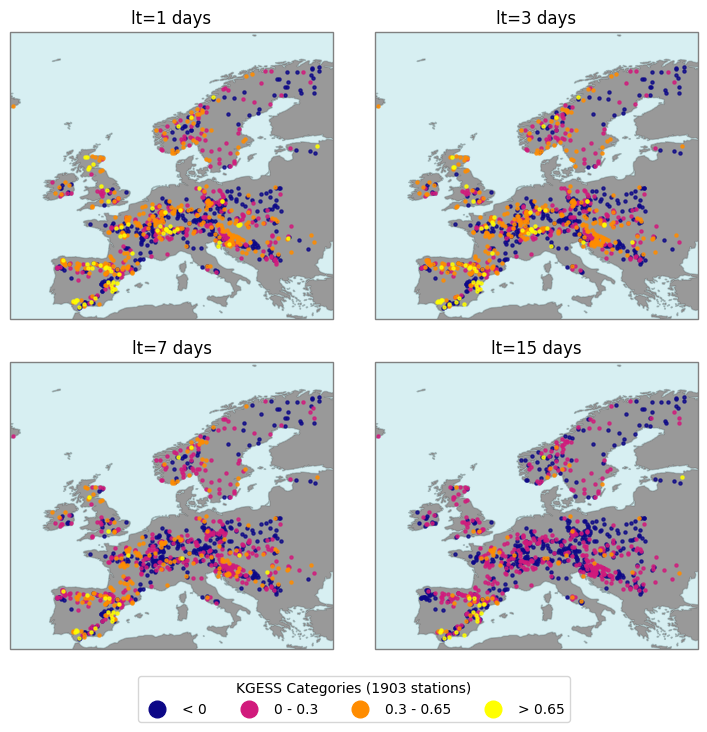

In [17]:
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')  # Load station metadata
lead_times = [3, 11, 27, 59]  # Choose desired lead times
plot_metric_spatial_multiple_lead_times(kgess_dict, station_info, lead_times, loaded_stations, 'kgess_map_multiple_lead_times.png', metric_name="KGESS", calibrated_only=True)

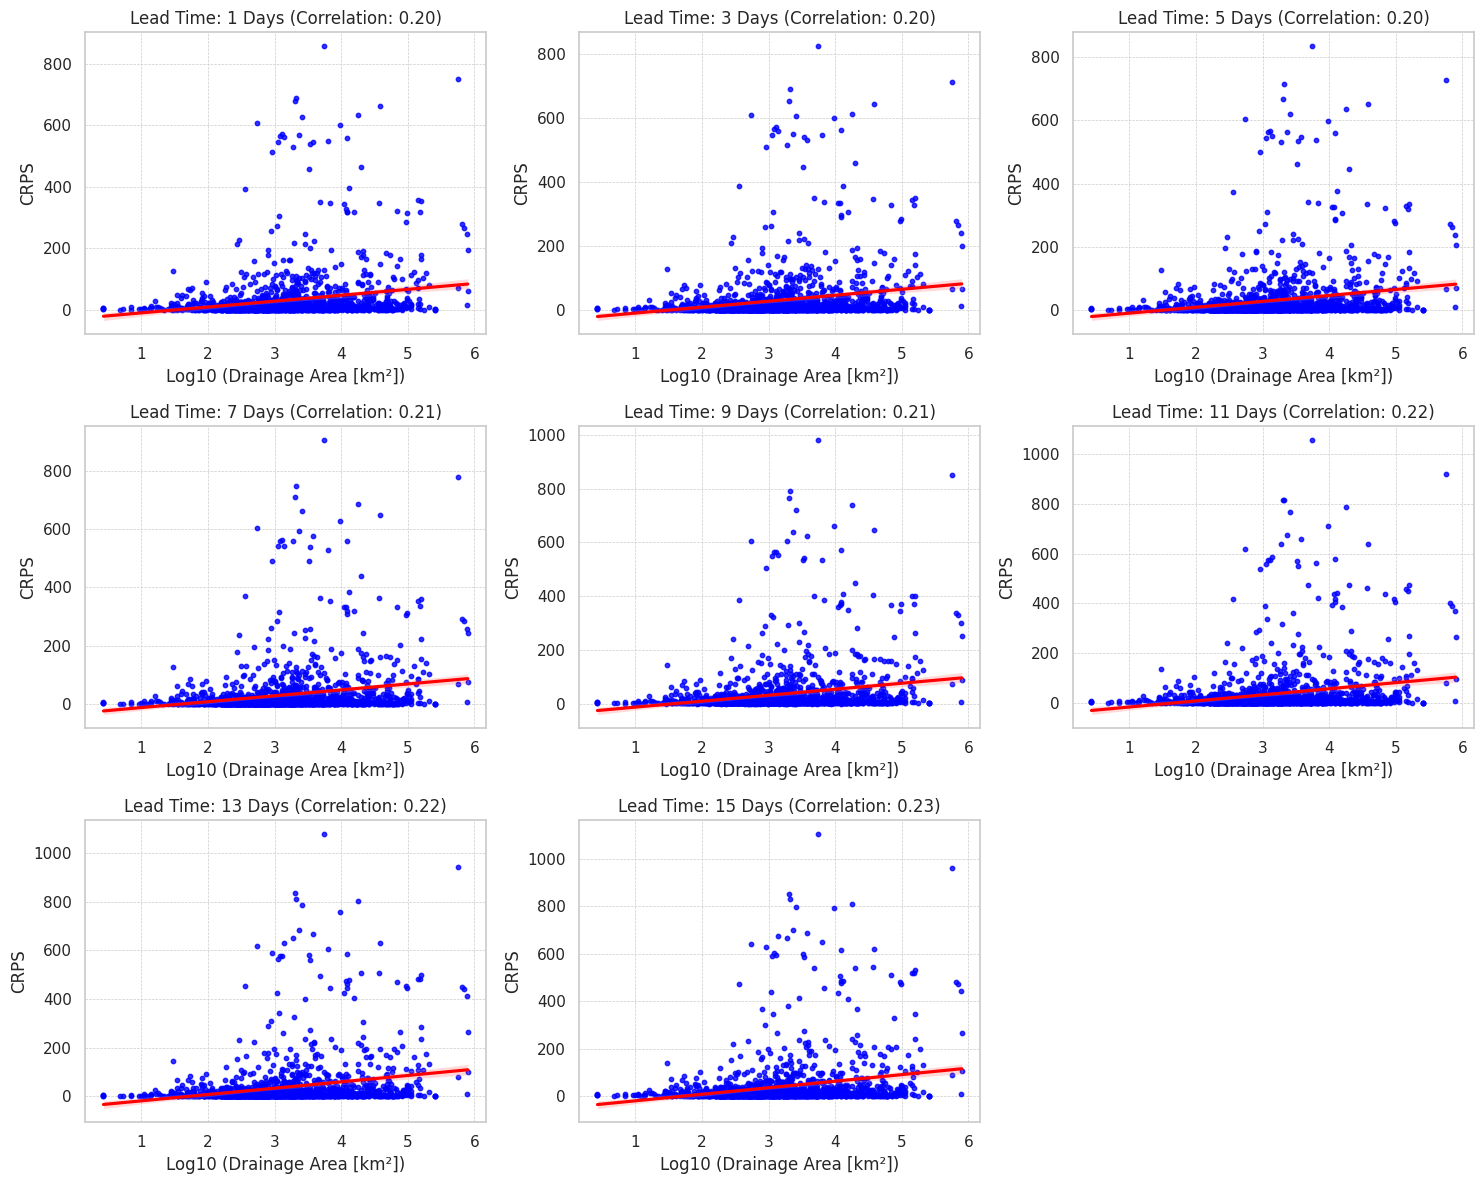

In [18]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CRPS results
crps_forecast_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_results.pkl"

with open(crps_forecast_path, "rb") as f:
    crps_forecast_dict = pickle.load(f)

# Load station info with drainage areas
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')
station_info = station_info[['ObsID', 'DrainingArea.km2.LDD']]

# Create a dictionary mapping ObsID to drainage area
drainage_area_dict = station_info.set_index('ObsID')['DrainingArea.km2.LDD'].to_dict()

# Define selected lead times in days (each day = 4 hourly time steps)
selected_days = [x for x in range(1, 16, 2)]
selected_time_steps = [(day * 4 - 1) for day in selected_days]

# Convert CRPS dictionary to DataFrame
crps_data = []
for lead_time, day in zip(selected_time_steps, selected_days):
    for station, crps_value in crps_forecast_dict.get(lead_time, {}).items():
        if not np.isnan(crps_value):  # Ignore NaN values
            drainage_area = drainage_area_dict.get(int(station), np.nan)
            if not np.isnan(drainage_area):  # Ensure drainage area is available
                crps_data.append([day, station, crps_value, drainage_area])

df_crps = pd.DataFrame(crps_data, columns=["Lead Time (Days)", "Station", "CRPS", "Drainage Area (km²)"])

# --- Correlation Plotting Function ---
def plot_crps_area_correlation(df_crps):
    """
    Plot correlation plots between CRPS and drainage area for different lead times, using log-transformed areas.
    """
    # Plotting settings
    sns.set(style="whitegrid")
    nrows = 3
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
    axes = axes.flatten()
    
    unique_days = sorted(df_crps['Lead Time (Days)'].unique())
    
    for i, day in enumerate(unique_days[:nrows * ncols]):
        ax = axes[i]
        
        # Filter data for the current lead time (day)
        subset = df_crps[df_crps['Lead Time (Days)'] == day].copy()
        
        # Apply log transformation to Drainage Area
        subset['Log Drainage Area (km²)'] = np.log10(subset['Drainage Area (km²)'])
        
        # Scatter plot with regression line
        sns.regplot(
            data=subset, 
            x="Log Drainage Area (km²)", 
            y="CRPS", 
            ax=ax, 
            scatter_kws={'s': 10, 'color': 'blue'}, 
            line_kws={'color': 'red'}
        )
        
        # Correlation coefficient calculation
        corr_value = subset['Log Drainage Area (km²)'].corr(subset['CRPS'])
        
        # Plot settings
        ax.set_title(f"Lead Time: {day} Days (Correlation: {corr_value:.2f})")
        ax.set_xlabel("Log10 (Drainage Area [km²])")
        ax.set_ylabel("CRPS")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Remove unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_crps_area_correlation(df_crps)



In [66]:
import pandas as pd

# Load your station info CSV file
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')

# Extract the relevant column
area_data = station_info['DrainingArea.km2.LDD']

# Calculate percentile thresholds
small_threshold = area_data.quantile(0.25)
small_2_threshold = area_data.quantile(0.5)
medium_threshold = area_data.quantile(0.75)
large_threshold = area_data.quantile(1.0)

# Print the thresholds with formatting
print(f"Very Small Threshold: <= {small_threshold:.1f} km²")
print(f"Small Threshold: <= {small_2_threshold:.1f} km²")
print(f"Medium Threshold: <= {medium_threshold:.1f} km²")
print(f"Large Threshold:  <= {large_threshold:.1f} km²")


Very Small Threshold: <= 209.1 km²
Small Threshold: <= 710.8 km²
Medium Threshold: <= 3232.2 km²
Large Threshold:  <= 794168.5 km²
